In [1]:
# Import required libraries
import amber as am
import networkx as nx
import numpy as np
import polars as pl

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
class ButtonAgent(am.Agent):
    """A button agent that can be connected to other buttons via threads."""
    
    def __init__(self, model, agent_id):
        super().__init__(model, agent_id)
        self.node_id = agent_id  # Node ID in the network graph
    
    def setup(self):
        pass

class ButtonModel(am.Model):
    """A model of randomly connecting buttons demonstrating network phase transitions."""
    
    def setup(self):
        """Initialize the model with buttons and an empty network."""
        
        # Initialize DataFrame with network-specific columns
        self.agents_df = pl.DataFrame({
            'id': pl.Series([], dtype=pl.Int64),
            'step': pl.Series([], dtype=pl.Int64),
            'degree': pl.Series([], dtype=pl.Int64),
            'cluster_size': pl.Series([], dtype=pl.Int64)
        })
        
        # Create button agents
        self.button_agents = {}
        for i in range(self.p['n']):
            agent = ButtonAgent(self, i)
            agent.setup()
            self.button_agents[i] = agent
        
        # Create network graph
        self.graph = nx.Graph()
        self.graph.add_nodes_from(range(self.p['n']))
        
        # Initialize thread counter
        self.threads = 0
        
        # Record initial state
        self._record_all_agents()
        
    def _record_all_agents(self):
        """Record current network state of all agents."""
        agent_data = []
        
        # Calculate connected components
        clusters = list(nx.connected_components(self.graph))
        cluster_sizes = {node: len(cluster) for cluster in clusters for node in cluster}
        
        for agent_id, agent in self.button_agents.items():
            degree = self.graph.degree(agent_id)
            cluster_size = cluster_sizes.get(agent_id, 1)
            
            agent_data.append({
                'id': agent_id,
                'step': self.t,
                'degree': degree,
                'cluster_size': cluster_size
            })
        
        if agent_data:
            new_data = pl.DataFrame(agent_data)
            self.agents_df = pl.concat([self.agents_df, new_data])

    def update(self):
        """Update model state and record metrics."""
        super().update()
        
        # Calculate network metrics
        if self.graph.number_of_nodes() > 0:
            # Find largest connected component
            clusters = list(nx.connected_components(self.graph))
            if clusters:
                max_cluster_size = max([len(cluster) for cluster in clusters]) / self.p['n']
            else:
                max_cluster_size = 1.0 / self.p['n']  # Single isolated nodes
        else:
            max_cluster_size = 0.0
        
        # Calculate threads to buttons ratio
        threads_to_button_ratio = self.threads / self.p['n']
        
        # Record model-level metrics
        self.record_model('max_cluster_size', max_cluster_size)
        self.record_model('threads_to_button', threads_to_button_ratio)
        self.record_model('total_threads', self.threads)
        self.record_model('num_components', nx.number_connected_components(self.graph))
        
        # Record agent states
        self._record_all_agents()
    
    def step(self):
        """Add random connections between buttons."""
        
        # Create random edges based on speed parameter
        connections_per_step = int(self.p['n'] * self.p['speed'])
        
        for _ in range(connections_per_step):
            # Select two random buttons
            button_ids = list(self.button_agents.keys())
            if len(button_ids) >= 2:
                button1, button2 = self.random.sample(button_ids, 2)
                
                # Add edge if it doesn't exist
                if not self.graph.has_edge(button1, button2):
                    self.graph.add_edge(button1, button2)
                    self.threads += 1
    
    def get_network_stats(self):
        """Get current network statistics for analysis."""
        clusters = list(nx.connected_components(self.graph))
        cluster_sizes = [len(cluster) for cluster in clusters]
        
        return {
            'num_nodes': self.graph.number_of_nodes(),
            'num_edges': self.graph.number_of_edges(),
            'num_components': len(clusters),
            'largest_component': max(cluster_sizes) if cluster_sizes else 0,
            'avg_degree': np.mean([d for n, d in self.graph.degree()]) if self.graph.number_of_nodes() > 0 else 0
        }


🔗 Running single button network simulation...
Parameters: {'n': 1000, 'speed': 0.05, 'steps': 30, 'seed': 42}
🚀 Starting simulation: ButtonModel
📊 Parameters: {'n': 1000, 'speed': 0.05, 'steps': 30, 'seed': 42}
⏱️  Total steps: 30
🕐 Started at: 19:54:28

🔄 Step 30/30 [██████████████████████████████] 100.0% | Elapsed: 0:00:00 | ETA: 0:00:00

✅ Simulation completed!
⏱️  Total time: 0:00:00
   • Setup: 0.004s
   • Steps: 0.040s (1.34ms/step)
   • Cleanup: 0.000s
📈 Performance: 671.0 steps/second
🕐 Finished at: 19:54:28
✅ Single run completed!

Final network statistics:
  num_nodes: 1000
  num_edges: 1448
  num_components: 51
  largest_component: 948
  avg_degree: 2.896


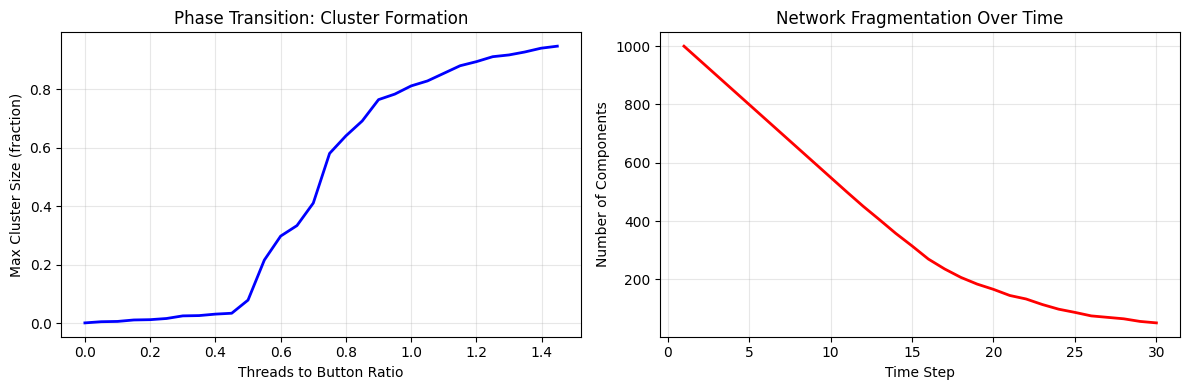

In [3]:
# Single run parameters
single_run_params = {
    'n': 1000,        # Number of buttons
    'speed': 0.05,    # Connection speed (connections per button per step)
    'steps': 30,      # Number of simulation steps
    'seed': 42
}

print("🔗 Running single button network simulation...")
print(f"Parameters: {single_run_params}")

# Run single simulation
model = ButtonModel(single_run_params)
results = model.run()

print("✅ Single run completed!")

# Display results
print(f"\nFinal network statistics:")
stats = model.get_network_stats()
for key, value in stats.items():
    print(f"  {key}: {value}")

# Plot the phase transition
model_data = results['model']

plt.figure(figsize=(12, 4))

# Plot 1: Max cluster size over threads/button ratio
plt.subplot(1, 2, 1)
plt.plot(model_data['threads_to_button'], model_data['max_cluster_size'], 'b-', linewidth=2)
plt.xlabel('Threads to Button Ratio')
plt.ylabel('Max Cluster Size (fraction)')
plt.title('Phase Transition: Cluster Formation')
plt.grid(True, alpha=0.3)

# Plot 2: Number of components over time
plt.subplot(1, 2, 2)
plt.plot(model_data['t'], model_data['num_components'], 'r-', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Number of Components')
plt.title('Network Fragmentation Over Time')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [4]:
# Define parameter ranges for multi-run experiment
# We need to manually create parameter combinations since AMBER doesn't have ap.Values

n_values = [100, 1000, 10000]  # Different network sizes
parameter_combinations = []

for n in n_values:
    parameter_combinations.append({
        'n': n,
        'speed': 0.05,
        'steps': 30
    })

print("🧪 Multi-run experiment parameters:")
for i, params in enumerate(parameter_combinations):
    print(f"  Combination {i+1}: {params}")

# Create a custom sample by manually running experiments
class CustomSample:
    def __init__(self, parameter_combinations):
        self.combinations = parameter_combinations
        self.n = len(parameter_combinations)

# Create custom sample
sample = CustomSample(parameter_combinations)

# Run experiment with multiple iterations
print(f"\n🚀 Running experiment with {len(sample.combinations)} parameter combinations...")

experiment = am.Experiment(ButtonModel, sample, iterations=10)  # Reduced iterations for demo
results = experiment.run()

print("✅ Multi-run experiment completed!")


🧪 Multi-run experiment parameters:
  Combination 1: {'n': 100, 'speed': 0.05, 'steps': 30}
  Combination 2: {'n': 1000, 'speed': 0.05, 'steps': 30}
  Combination 3: {'n': 10000, 'speed': 0.05, 'steps': 30}

🚀 Running experiment with 3 parameter combinations...
🚀 Starting simulation: ButtonModel
📊 Parameters: {'n': 100, 'speed': 0.05, 'steps': 30, 'iteration': 0}
⏱️  Total steps: 30
🕐 Started at: 19:54:28

🔄 Step 30/30 [██████████████████████████████] 100.0% | Elapsed: 0:00:00 | ETA: 0:00:00

✅ Simulation completed!
⏱️  Total time: 0:00:00
   • Setup: 0.011s
   • Steps: 0.013s (0.43ms/step)
   • Cleanup: 0.000s
📈 Performance: 801.9 steps/second
🕐 Finished at: 19:54:28
🚀 Starting simulation: ButtonModel
📊 Parameters: {'n': 100, 'speed': 0.05, 'steps': 30, 'iteration': 1}
⏱️  Total steps: 30
🕐 Started at: 19:54:28

🔄 Step 30/30 [██████████████████████████████] 100.0% | Elapsed: 0:00:00 | ETA: 0:00:00

✅ Simulation completed!
⏱️  Total time: 0:00:00
   • Setup: 0.001s
   • Steps: 0.007s (0

📊 Processing experiment results...
Available columns: ['t', 'max_cluster_size', 'threads_to_button', 'total_threads', 'num_components', 'n', 'speed', 'steps', 'iteration']
Model data shape: (900, 9)


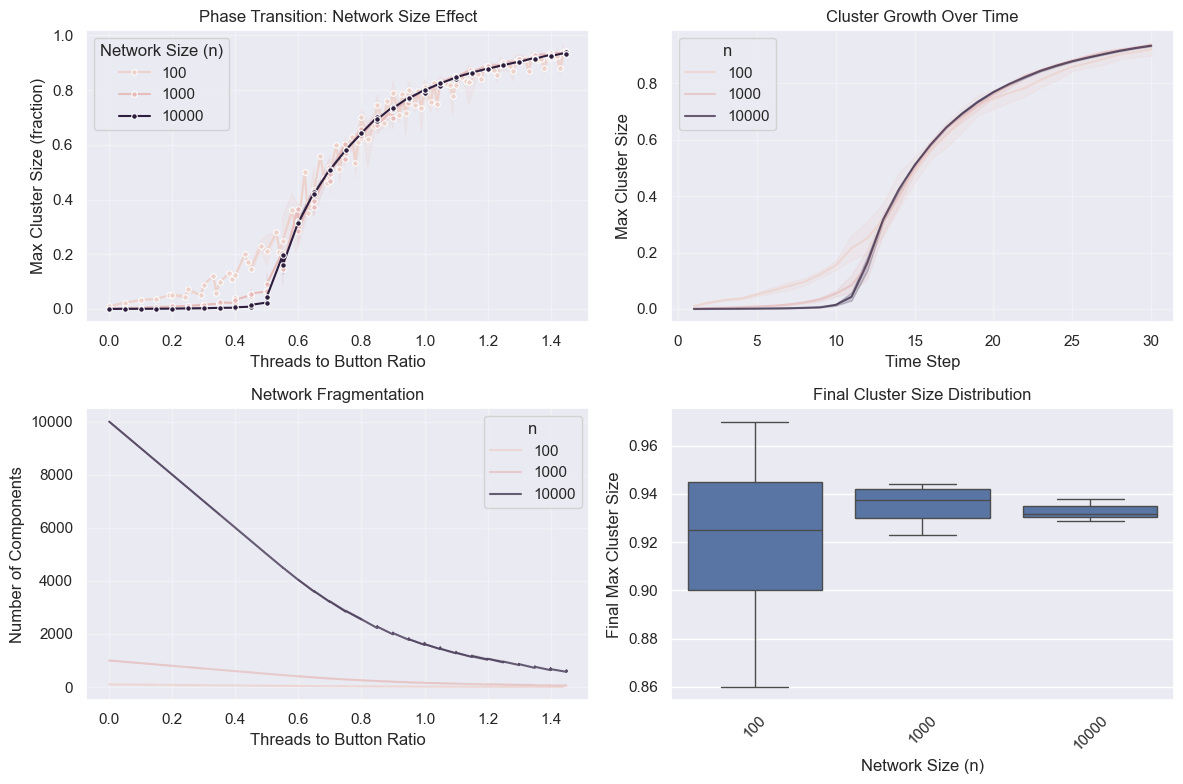


📈 Summary Statistics:
shape: (3, 4)
┌───────┬───────────────────┬────────────────────┬────────────────┐
│ n     ┆ peak_cluster_size ┆ critical_threshold ┆ min_components │
│ ---   ┆ ---               ┆ ---                ┆ ---            │
│ i32   ┆ f64               ┆ f64                ┆ i64            │
╞═══════╪═══════════════════╪════════════════════╪════════════════╡
│ 100   ┆ 0.97              ┆ 0.65               ┆ 4              │
│ 1000  ┆ 0.944             ┆ 0.698              ┆ 49             │
│ 10000 ┆ 0.9381            ┆ 0.6999             ┆ 574            │
└───────┴───────────────────┴────────────────────┴────────────────┘


In [5]:
# Process results for visualization
print("📊 Processing experiment results...")

# Extract model data from results
model_data = results['model']

# Check available columns
print(f"Available columns: {model_data.columns}")
print(f"Model data shape: {model_data.shape}")

# Convert to pandas for seaborn plotting
model_data_pd = model_data.to_pandas()

# Create the main phase transition plot
sns.set_theme()
plt.figure(figsize=(12, 8))

# Main plot: Phase transition curves for different network sizes
plt.subplot(2, 2, 1)
sns.lineplot(
    data=model_data_pd, 
    x='threads_to_button', 
    y='max_cluster_size', 
    hue='n',
    marker='o',
    markersize=4
)
plt.title('Phase Transition: Network Size Effect')
plt.xlabel('Threads to Button Ratio')
plt.ylabel('Max Cluster Size (fraction)')
plt.grid(True, alpha=0.3)
plt.legend(title='Network Size (n)')

# Additional analysis plots
plt.subplot(2, 2, 2)
sns.lineplot(
    data=model_data_pd,
    x='t',
    y='max_cluster_size',
    hue='n',
    alpha=0.7
)
plt.title('Cluster Growth Over Time')
plt.xlabel('Time Step')
plt.ylabel('Max Cluster Size')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
sns.lineplot(
    data=model_data_pd,
    x='threads_to_button',
    y='num_components',
    hue='n',
    alpha=0.7
)
plt.title('Network Fragmentation')
plt.xlabel('Threads to Button Ratio')
plt.ylabel('Number of Components')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
# Calculate final max cluster size for each run
final_cluster_sizes = model_data.group_by(['n', 'iteration']).agg([
    pl.col('max_cluster_size').last().alias('final_max_cluster')
])

final_cluster_pd = final_cluster_sizes.to_pandas()
sns.boxplot(data=final_cluster_pd, x='n', y='final_max_cluster')
plt.title('Final Cluster Size Distribution')
plt.xlabel('Network Size (n)')
plt.ylabel('Final Max Cluster Size')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📈 Summary Statistics:")
summary_stats = model_data.group_by('n').agg([
    pl.col('max_cluster_size').max().alias('peak_cluster_size'),
    pl.col('threads_to_button').filter(pl.col('max_cluster_size') > 0.5).min().alias('critical_threshold'),
    pl.col('num_components').min().alias('min_components')
])

print(summary_stats)
